In [65]:
import pandas as pd
import numpy as np
import seaborn as sns
import re

import matplotlib.pyplot as plt

In [66]:
#Functions
from sklearn.metrics import roc_curve

#Plot histogram and boxplot per column
def plot_hist_box_col(df, column):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    fig.suptitle(f'{column} plots')
    ax1.hist(df[column])
    ax1.axvline(df[column].mean(), color='r', linestyle='dashed', label='Mean')
    ax1.axvline(df[column].median(), color='b', linestyle='dashed', label='Median')
    ax1.legend(loc='upper right')
    ax1.set_title(f'Histogram of {column}')
    ax2.boxplot(df[column])
    ax2.set_title(f'Box plot of {column}')

#Analisys of outliers
def outliers_analisis(df, column):
    q3 = df[column].quantile(0.75)
    q1 = df[column].quantile(0.25)
    iqr = q3 - q1
    max_outlier = q3 + 1.5*iqr
    min_outlier = q1 - 1.5*iqr

    print(f'The Q1 of {column} is: {round(q1, 0)}')
    print(f'The Q3 of {column} is: {round(q3, 0)}')
    print(f'The interquartile of {column} is: {round(iqr, 0)}')
    print(f'The min outlier is {round(min_outlier, 0)}')
    print(f'The max outlier is {round(max_outlier, 0)}')

    #In the interquartile
    n_iqr = df[column][(df[column] <= max_outlier) & (df[column] >= min_outlier)].count()
    print(f'There are {n_iqr} in the interquartile range')

    #Quantity of min outliers
    n_min_outliers = df[column][df[column] < min_outlier].count()
    print(f'There are {n_min_outliers} min outliers')

    #Quantity of max outliers
    n_max_outliers = df[column][df[column] > max_outlier].count()
    print(f'There are {n_max_outliers} max outliers')

    #Percentage of outliers
    percentage_outliers = (n_min_outliers + n_max_outliers)/len(df)*100
    print(f'The percentage of outliers is {percentage_outliers:.2}%')


#Plot the roc curve with the idea to compare the models.
def plot_roc_curve(fpr, tpr, label):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

Frame the problem
- Objetives
    Model
        - Have at least 80% of acc
        - Predict if the recipe it would be popular
    Business
        - Wich recipes display on the home page
            -> More traffic -> More suscriptions

- Bussiness mission
    Full meal plan -> Healthy, balanced diet


- Conclusions
    - Supervised learning problem
    - Classification task (binary)
    - Batch learning technique 

Select Perfomance Measure

Since is a Classification task, there are many ways to compute the results of the prediction. In this case its better to focus in False Negative than False Positive preditions, throgh the recall indicator. In addition it would be a good guide use Accuracy (by the user request) and ROC AUC meassurements.

In [67]:
#Read the dataset
df = pd.read_csv('recipe_site_traffic_2212.csv')

#Getting the first 3 rows
df.head(3)

,recipe,calories,carbohydrate,sugar,protein,category,servings,high_traffic
0,1,NaN,NaN,NaN,NaN,Pork,6,High
1,2,35.48,38.56,0.66,0.92,Potato,4,High
2,3,914.28,42.68,3.09,2.88,Breakfast,1,NaN


In [68]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 947 entries, 0 to 946
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   recipe        947 non-null    int64  
 1   calories      895 non-null    float64
 2   carbohydrate  895 non-null    float64
 3   sugar         895 non-null    float64
 4   protein       895 non-null    float64
 5   category      947 non-null    object 
 6   servings      947 non-null    object 
 7   high_traffic  574 non-null    object 
dtypes: float64(4), int64(1), object(3)
memory usage: 59.3+ KB


In [69]:
len_category = len(df.category.unique())
len_servings = len(df.servings.unique())
len_high_traffic = len(df.high_traffic.unique())

print(f'The column category have {len_category} unique values')
print(f'The column servings have {len_servings} unique values')
print(f'The column high_traffic have {len_high_traffic} unique values')

The column category have 11 unique values
The column servings have 6 unique values
The column high_traffic have 2 unique values


The Data has 8 columns with 947 rows, in the info output we can analise:

- The column recipe is a index column
- The columns recipe, category and servings dont have null values
- There are 5 columns with numeric data: recipe, calories, carbohydrate, ugar and protein.
- There are 3 object columns:
    - category:  11 unique values
    - servings: 6 unique values
    - high_traffic: 2 unique values


- The target column is: high_traffic

Cleanning the data

Analysis:
- The recipe is a index column, so it'll be deleted
- The servings column it has to be a int value as the amount of the result of the preparation of the recipe.

In [70]:
#Unique values of the serving column
print(df.servings.unique())

['6' '4' '1' '2' '4 as a snack' '6 as a snack']


In [71]:
#Quantity of Lunch/Snacks rows
len_lunch_snack=len(df[df['category'] == 'Lunch/Snacks'])
print(f'The category Lunch/Snacks have {len_lunch_snack} rows')

#Row of servings with string
df[df['servings'].isin(['4 as a snack', '6 as a snack'])]

The category Lunch/Snacks have 89 rows


,recipe,calories,carbohydrate,sugar,protein,category,servings,high_traffic
451,452,1542.53,14.73,5.71,29.92,Lunch/Snacks,4 as a snack,High
548,549,1440.69,30.59,5.78,30.63,Lunch/Snacks,6 as a snack,High
735,736,513.75,65.87,18.63,18.39,Lunch/Snacks,4 as a snack,NaN


There are not sufficient information to validate if the category 'Lunch/Snacks' with servings 'n' as a snack, are snacks. Dividing this category in two (Luch and Snack) may be a good opportunity to improve future analysis.

I'll deleted the string detail from the serving columns, because I assumed the number of servings is indifferent to the type of food

In [72]:
#Cleanning the serving column: delete strings and spaces
def only_numbers(text):
    return re.sub(r'[A-Za-z ]', '', text)

#Applying que the cleanning function and changing the type of the column
df['servings'] = df.servings.apply(only_numbers).astype(int)

#Drop the recipe column, because in this case is useless
df.drop(columns='recipe', inplace=True)

In [73]:
#Sum per column of null values
df.isna().sum()

calories         52
carbohydrate     52
sugar            52
protein          52
category          0
servings          0
high_traffic    373
dtype: int64

By this output* all columns have the nan rows (52) together


*df[df['calories'].isna()]

In [74]:
#For more detail I created a dataframe with the nan values
dataframe_nan = df[df['calories'].isna()]

In [75]:
#The nan values is in almoust all the features, it would be better delete those rows to not adjust the model with a fill method.
df = df[~df['calories'].isna()]

In [76]:
#It seems the label has only one type of variable, so it a fact the nan values are Non high recipes.
print(df.high_traffic.value_counts())

High    535
Name: high_traffic, dtype: int64


In [77]:
target = {1: 'High', 0: 'NonHigh'}
df['high_traffic'] = df.high_traffic.apply(lambda x: int(x == 'High'))

Conclusions
- Its possible to increase the results modifiying the column category.
- In the services column, only numerical data was considered and due to the number of records (3) the Lunch/Snacks category was not separated or a new bool column was created. So in the future as not to lose this information is posible to take a decision on this.
- 52 records were eliminated because none of the numerical columns had values, so there is a lot of risk in replacing all the columns in a single row.
- In the label column, nan values were assumed to be the non-high recipes.

Single column Analisys

The Q1 of calories is: 110.0
The Q3 of calories is: 598.0
The interquartile of calories is: 487.0
The min outlier is -620.0
The max outlier is 1328.0
There are 848 in the interquartile range
There are 0 min outliers
There are 47 max outliers
The percentage of outliers is 5.3%


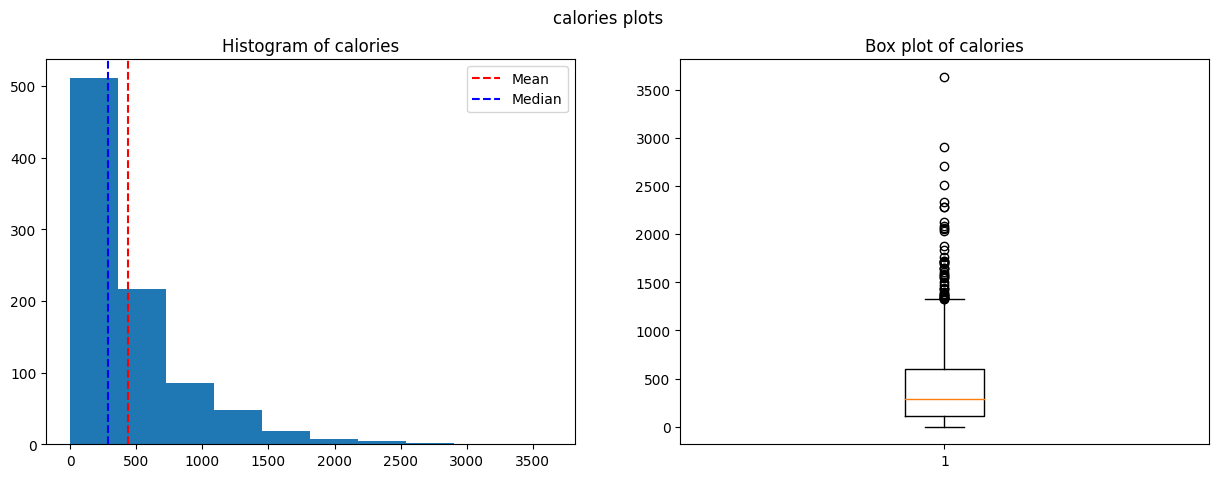

In [78]:
outliers_analisis(df, 'calories')
plot_hist_box_col(df, 'calories')
plt.show()

The Q1 of carbohydrate is: 8.0
The Q3 of carbohydrate is: 45.0
The interquartile of carbohydrate is: 37.0
The min outlier is -47.0
The max outlier is 100.0
There are 837 in the interquartile range
There are 0 min outliers
There are 58 max outliers
The percentage of outliers is 6.5%


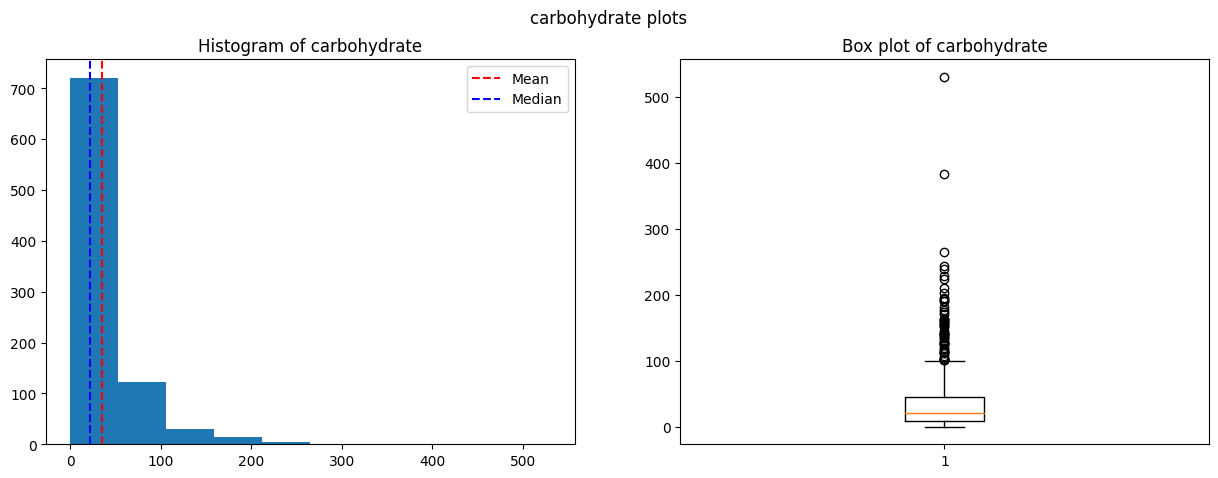

In [79]:
outliers_analisis(df, 'carbohydrate')
plot_hist_box_col(df, 'carbohydrate')
plt.show()

The Q1 of sugar is: 2.0
The Q3 of sugar is: 10.0
The interquartile of sugar is: 8.0
The min outlier is -10.0
The max outlier is 22.0
There are 816 in the interquartile range
There are 0 min outliers
There are 79 max outliers
The percentage of outliers is 8.8%


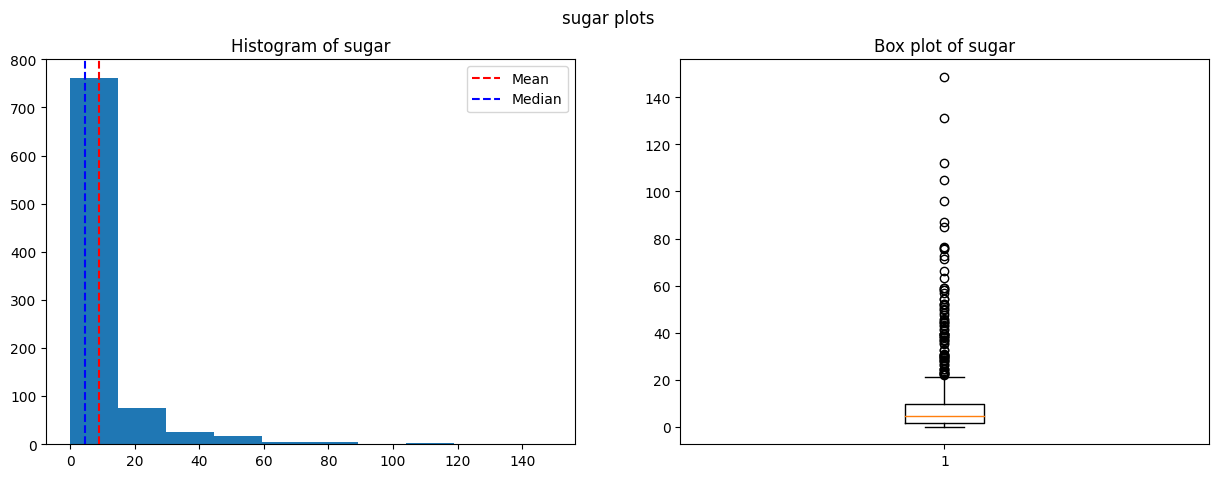

In [80]:
outliers_analisis(df, 'sugar')
plot_hist_box_col(df, 'sugar')
plt.show()

The Q1 of protein is: 3.0
The Q3 of protein is: 30.0
The interquartile of protein is: 27.0
The min outlier is -37.0
The max outlier is 71.0
There are 818 in the interquartile range
There are 0 min outliers
There are 77 max outliers
The percentage of outliers is 8.6%


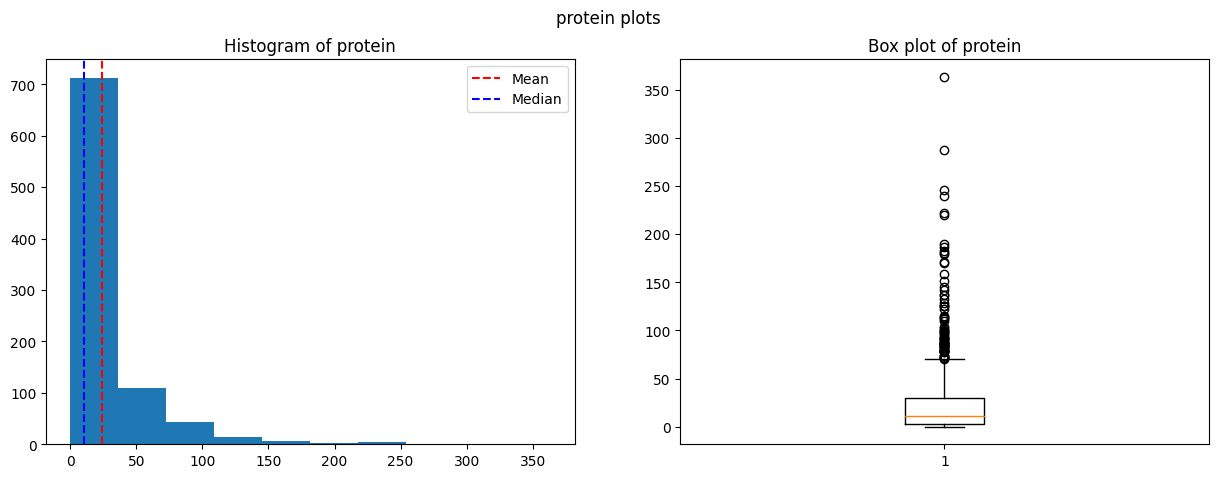

In [81]:
outliers_analisis(df, 'protein')
plot_hist_box_col(df, 'protein')
plt.show()

The Q1 of servings is: 2.0
The Q3 of servings is: 4.0
The interquartile of servings is: 2.0
The min outlier is -1.0
The max outlier is 7.0
There are 895 in the interquartile range
There are 0 min outliers
There are 0 max outliers
The percentage of outliers is 0.0%


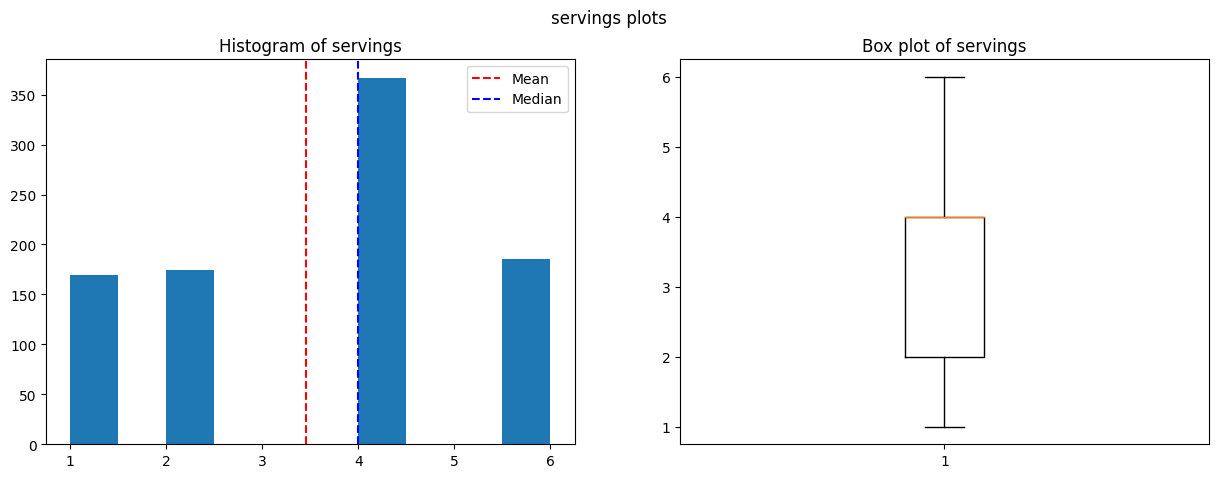

In [82]:
outliers_analisis(df, 'servings')
plot_hist_box_col(df, 'servings')
plt.show()

There are many (not more than the 10%) values outside of the max range in the columns:
- Calories: 58
- Carbohydrate: 58
- Sugar:79
- Protein: 77

It would be possible to disturb the prediction, for the momment, they will be maintained in order not to reduce the number of rows.

- Servings: It's not necessary to take a look to outliers in servings column

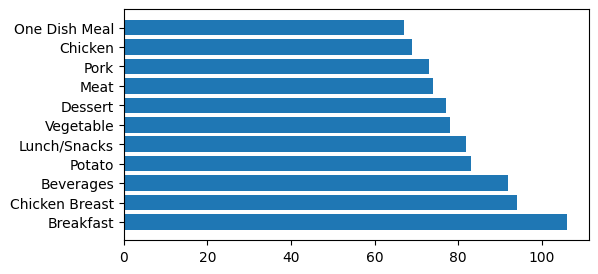

In [83]:
column = 'category'

categories = df[column].value_counts().keys()
count_categories = list(df[column].value_counts().values)
plt.figure(figsize=(6, 3))
plt.barh(categories, count_categories)
plt.show()

In [84]:
df[column].value_counts()

Breakfast         106
Chicken Breast     94
Beverages          92
Potato             83
Lunch/Snacks       82
Vegetable          78
Dessert            77
Meat               74
Pork               73
Chicken            69
One Dish Meal      67
Name: category, dtype: int64

In [86]:
df['category'].replace('Chicken Breast', 'Chicken', inplace=True)
df['category'].value_counts()

Chicken          163
Breakfast        106
Beverages         92
Potato            83
Lunch/Snacks      82
Vegetable         78
Dessert           77
Meat              74
Pork              73
One Dish Meal     67
Name: category, dtype: int64

In [58]:
df['high_traffic'].value_counts()

1    535
0    360
Name: high_traffic, dtype: int64

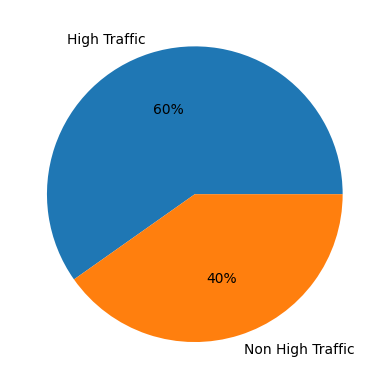

In [62]:
plt.pie(df['high_traffic'].value_counts(), labels=['High Traffic', 'Non High Traffic'],autopct='%.0f%%')
plt.show()

In [20]:
#Deleting Outliers with 3 times the interquartile
list_outlier = ['calories', 'carbohydrate', 'sugar', 'protein']

#Loop for the numeric features
for column in list_outlier:
    q3 = df[column].quantile(0.75)
    q1 = df[column].quantile(0.25)
    iqr = q3 - q1

    #Calculating the 3 times interquartile in the min and max limit
    max_outlier = q3 + 3*iqr
    min_outlier = q1 - 3*iqr

    # quantity of rows before the outliers
    n_init = len(df)

    #Outlier elimination
    df = df[(df[column] <= max_outlier) & (df[column] >= min_outlier)]
    
    # quantity of rows after the outliers
    n_out = len(df)

    print(f'{n_init-n_out} records have been eliminated due to outliers in the column: {column}')

10 records have been eliminated due to outliers in the column: calories
24 records have been eliminated due to outliers in the column: carbohydrate
47 records have been eliminated due to outliers in the column: sugar
24 records have been eliminated due to outliers in the column: protein


After to take a look of the categories, is possible to group them and create a new column with the meals of the day:

- Breakfast
- Lunch
- Dinner

For future analyses it would be a great opportunity to increase the recommendations.

Target analisys

Conclusions
- There are less than 10% outliers per column, so they will be cleaned, but after a few test the optimun value of the constant 1.5 increse to 3, then fewer rows were eliminated (105 rows).  
- The columns: calories, carbohydrate, sugar and protein are right-skewed.
- Its possible to redefine the category column

Multiple column analysis

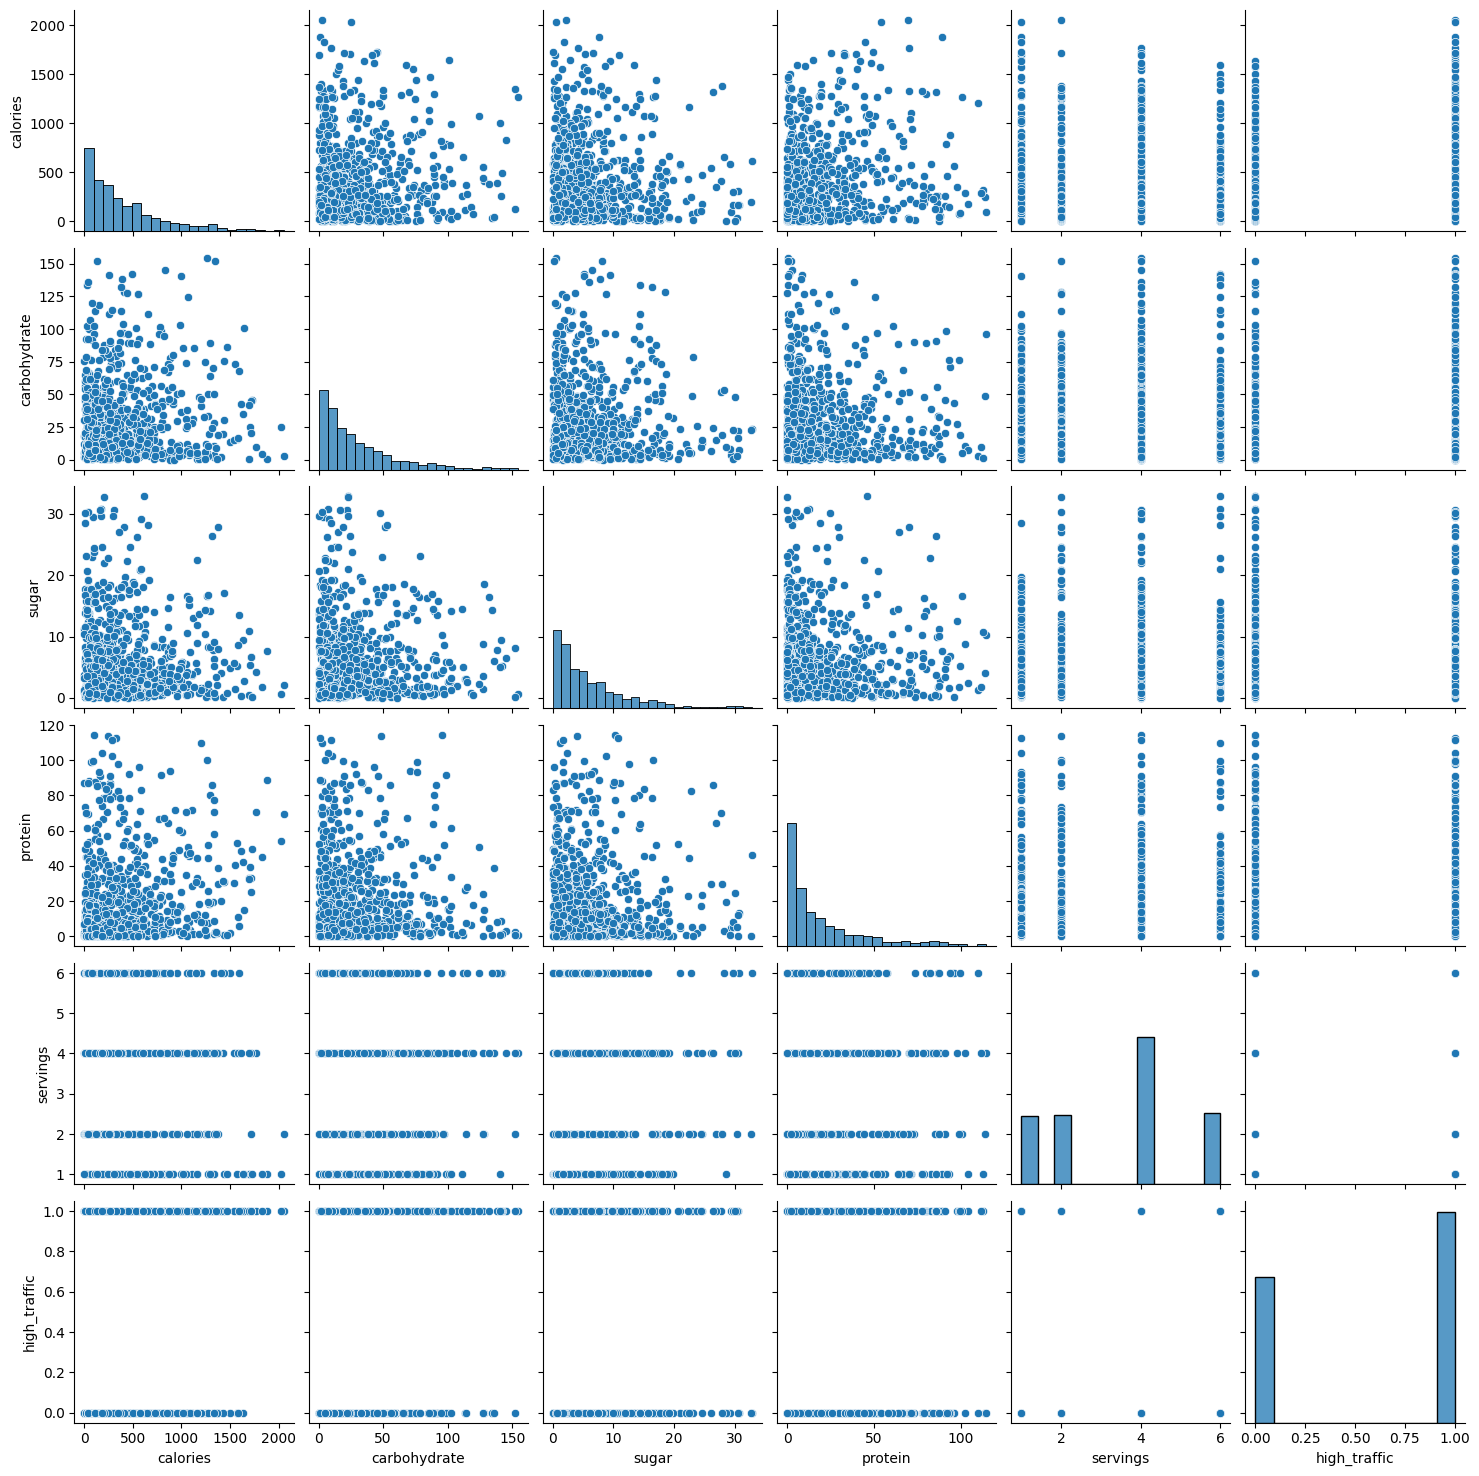

In [21]:
#Multiple column analisys
sns.pairplot(df)
plt.show()

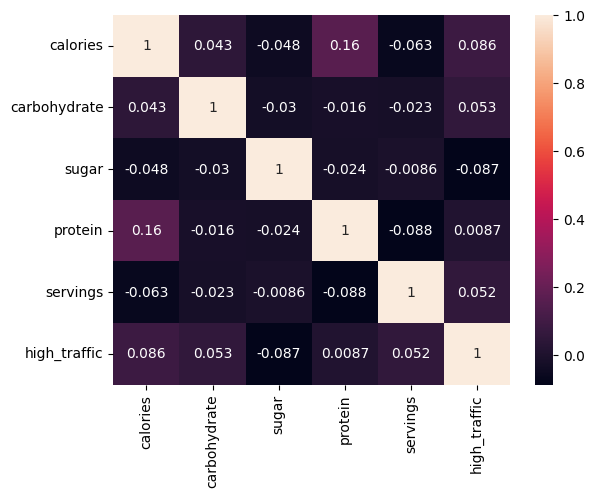

In [22]:
#Correlation matrix of all columns
sns.heatmap(df.corr(numeric_only=True), annot=True)
plt.show()

Conclusions
- After incressing the constant of the max interval of the features to decresse the outliers, it seems the skewed of the numerical data decreased. 
- There is not strong correlation between the independet variables.
- The popularity of the recipe is affected inversely by the ammount of sugar
- In summary, the columns have a good correlation, so the model is possible to not adjust to just one feature.
- After the Data validation and EDA, 157 rows were eliminated

Model Development
- Supervised Learning Problem
- Binary Classification

Transformations:
- The column category to a dummy columns (one column per category)
- Standarization of the numeric values to the same scale. 

In [23]:
#Getting the dummies of the category column
df = pd.get_dummies(df)

In [24]:
#Declaring the label feature
label = 'high_traffic'

#List of column for the features
features = list(df.columns)
features.remove(label)

print(f'Feature list {features}')
print(f'Target column {label}')

Feature list ['calories', 'carbohydrate', 'sugar', 'protein', 'servings', 'category_Beverages', 'category_Breakfast', 'category_Chicken', 'category_Chicken Breast', 'category_Dessert', 'category_Lunch/Snacks', 'category_Meat', 'category_One Dish Meal', 'category_Pork', 'category_Potato', 'category_Vegetable']
Target column high_traffic


In [25]:
from sklearn.model_selection import train_test_split

#Creation of the train and test sets
x_train, x_test, y_train, y_test = train_test_split(df[features], df[label], test_size=0.2, random_state=42)

In [26]:
from sklearn.preprocessing import StandardScaler

#Standardize columns
sscaler = StandardScaler()

#Adjusting and transforming the scaler to the train data
x_train = sscaler.fit_transform(x_train)

#Transforming the test data by train data
x_test = sscaler.transform(x_test)

In [27]:
#Reset index to split with the x_train set, since is a array variable not a DataFrame after the preprocess.
y_train.reset_index(inplace=True, drop=True)

In [28]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.base import clone

#Defining base model
lr = LogisticRegression(random_state=42, max_iter=200)
best_acc = 0

skfolds = StratifiedKFold(n_splits=10, random_state=42, shuffle=True)

for train_index, val_index in skfolds.split(x_train, y_train):
    clone_lr = clone(lr)

    x_train_fold = x_train[train_index]
    y_train_fold = (y_train[train_index])

    x_val_fold = x_train[val_index]
    y_val_fold = (y_train[val_index])

    lr.fit(x_train_fold, y_train_fold)
    y_pred = lr.predict(x_val_fold)
    acc = accuracy_score(y_val_fold, y_pred)

    if acc > best_acc:
        print(f'{acc:.2}')
        best_acc = acc
        best_model = lr

# Saving the predictions
y_pred_lr = lr.predict(x_test)

0.73
0.89


In [29]:
from sklearn.ensemble import GradientBoostingClassifier

#Defining baseline model
boost = GradientBoostingClassifier(
    loss='log_loss',
    learning_rate=0.01,
    n_estimators=200,
    random_state=42
)
#Fit the model
boost.fit(x_train, y_train)

# Saving the predictions
y_pred_boost = boost.predict(x_test)

In [64]:
y_test.value_counts()

1    91
0    67
Name: high_traffic, dtype: int64

In [30]:
from sklearn.metrics import accuracy_score, recall_score, roc_auc_score

acc_lr = round(accuracy_score(y_test, y_pred_lr)*100, 1)
recall_lr = round(recall_score(y_test, y_pred_lr)*100, 1)
auc_lr = round(roc_auc_score(y_test, y_pred_lr)*100, 1)

print('*'*30)
print('Logistic Regression results:')
print(f'Accuracy score: {acc_lr}%')
print(f'Recall score: {recall_lr}%')
print(f'ROC ACU score: {auc_lr}%')

print('*'*30)
print(' ')
print('*'*30)
acc_boost = round(accuracy_score(y_test, y_pred_boost)*100, 1)
recall_boost = round(recall_score(y_test, y_pred_boost)*100, 1)
auc_boost = round(roc_auc_score(y_test, y_pred_boost)*100, 1)

print('Graddient Boosting results:')
print(f'Accuracy score: {acc_boost}%')
print(f'Recall score: {recall_boost}%')
print(f'ROC ACU score: {auc_boost}%')
print('*'*30)

******************************
Logistic Regression results:
Accuracy score: 79.7%
Recall score: 75.8%
ROC ACU score: 80.4%
******************************
 
******************************
Graddient Boosting results:
Accuracy score: 83.5%
Recall score: 87.9%
ROC ACU score: 82.8%
******************************


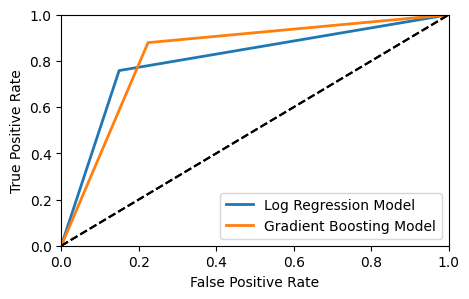

In [31]:
fpr_lr, tpr_lr, thresholds_lr = roc_curve(y_test, y_pred_lr)
fpr_boost, tpr_boost, thresholds_boost = roc_curve(y_test, y_pred_boost)

plt.figure(figsize=(5, 3))
plot_roc_curve(fpr_lr, tpr_lr, 'Log Regression Model')
plot_roc_curve(fpr_boost, tpr_boost, 'Gradient Boosting Model')
plt.legend()
plt.show()

Conclusions

******************************
Logistic Regression results:
Accuracy score: 79.7%
Recall score: 75.8%
ROC ACU score: 80.4%
******************************
 
******************************
Graddient Boosting results:
Accuracy score: 83.5%
Recall score: 87.9%
ROC ACU score: 82.8%
******************************

- The Gradient boosting Classifier perform better than the Logictic Regression model in the data.
- After a few tests the team archive a 83.5% of accuracy and 87.9% in the recall score, so there are around 88% of chance to publish a high recipe.
- There are many ideas that can increase the model complexity to improve the prediction, for example in the input data, for example:
    - Data validation in the important columns*, then the data is not deleted in the dataset and the model can have more information where it can learn.
    - We can add the recipe name, preparation and ingredients with the idea to make a relationship with this columns with a NLP process to have more information that the user use.
    - With the description, its possible to predict the category of the food and avoid user manipulation.
    - In addition, its possible to make test with more nutritional data, like vitamins or minerals.

- Its possible to have around 5% more in the recall score, decreassing the number of estimators in the Gradient boosting classifier, but compromising the model accuracy. This is the moment to take a decision if the managers only want to pay attention to the True Positive predictions.


After its approval, the team will deploy the model to production and use the recall score to continuisly measure the model and it'll be trained automaticaly with new data at the end of each month and evaluate to find improvements. 